In [1]:
import cv2
import json
import os
from collections import defaultdict
from tqdm import tqdm
import zipfile
from gluoncv import utils
import mxnet as mx
import numpy as np
from matplotlib import pyplot as plt
from gluoncv.data import LstDetection
import sys
import subprocess
from glob import glob
%matplotlib inline

In [2]:
dict_class = {
    'taxi':0,
#     'taxi_beijing':0,
#     'taxi_sichuan':0,
#     'taxi_tianjin':0,
#     'taxi_xinjiang':0,
    'tax':1,
#     'tax_beijing':1,
    'quo':2,
#     'quota_tianjin':2,
#     'quota_sichuan':2,
#     'quota_shanghai':3,
    'general':3,
    'train':4,
    'road':5,
    'plane':6
}

dict_orientation = {'0': 0,
                    '90': 1,
                    '180': 2,
                    '270': 3}

In [3]:
def write_line(img_path, img_w,img_h, boxes, ids, orientation, idx):
    # h, w, c = im_shape
    # for header, we use minimal length 2, plus width and height
    # with A: 4, B: 5, C: width, D: height
    A = 4
    B = 6
    C = img_w
    D = img_h
    # concat id and bboxes
    labels = np.hstack((ids.reshape(-1, 1), boxes, orientation.reshape(-1,1))).astype('float')
    # normalized bboxes (recommanded)
    labels[:, (1, 3)] /= float(img_w)
    labels[:, (2, 4)] /= float(img_h)
    # flatten
    labels = labels.flatten().tolist()
    str_idx = [str(idx)]
    str_header = [str(x) for x in [A, B, C, D]]
    str_labels = [str(x) for x in labels]
    str_path = [img_path]
    line = '\t'.join(str_idx + str_header + str_labels + str_path) + '\n'
    return line

def get_cls(cls):
    if 'tax' in cls and 'taxi' not in cls:return dict_class.get('tax')
    for i in dict_class.keys():
        if i in cls:
            return dict_class.get(i)
    

In [4]:
json_dir_beijing = '/ROOT/data/datasets/OCR/data_0703/beijing/Annotations/*.json'
img_dir_beijing = '/ROOT/data/datasets/OCR/data_0703/beijing/JPEGImages/'

json_dir_tianjin = '/ROOT/data/datasets/OCR/data_0703/tianjin/Annotations/*.json'
img_dir_tianjin = '/ROOT/data/datasets/OCR/data_0703/tianjin/JPEGImages/'

json_dir_mixture = '/ROOT/data/datasets/OCR/北京+天津数据/多票/*.json'
img_dir_mixture = '/ROOT/data/datasets/OCR/北京+天津数据/多票'

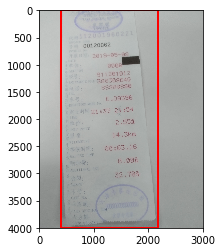

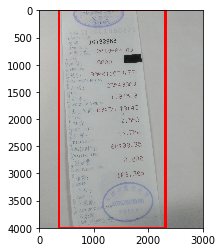

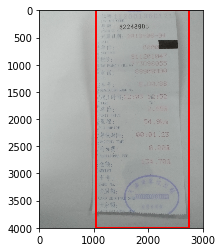

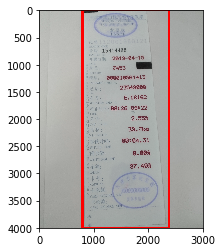

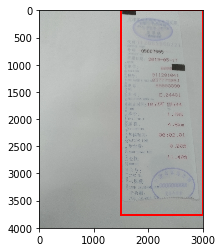

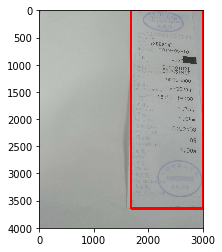

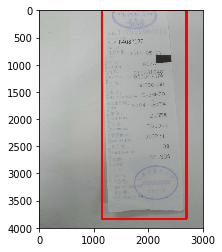

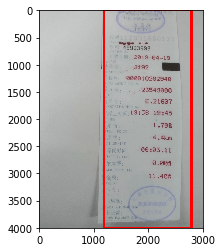

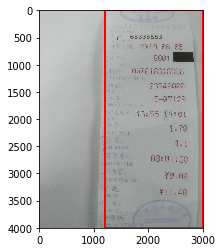

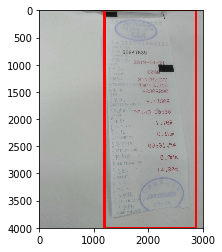

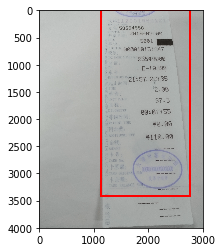

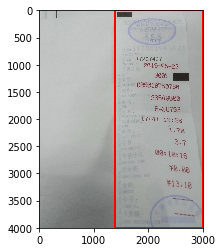

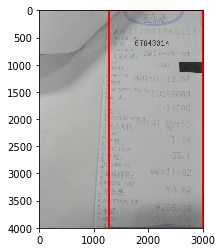

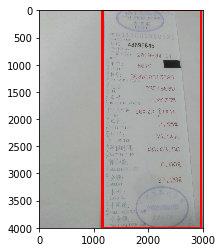

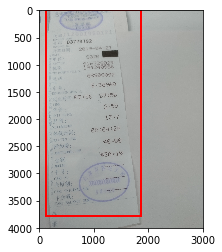

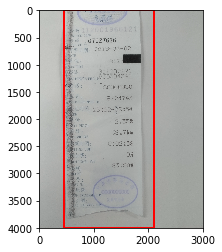

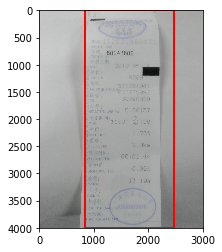

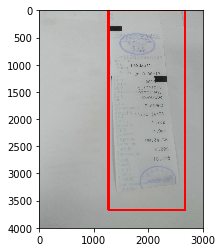

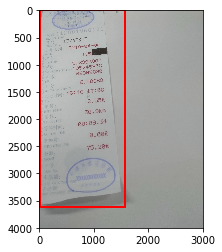

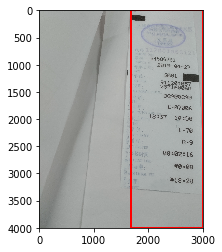

In [65]:
json_list = glob(json_path_beijing)
for i in range(20):
    with open(json_list[i],'r',encoding='ISO-8859-1') as f:
        j = json.load(f)
        img_name = j['imagePath']
        img_h = j['imageHeight']
        img_w = j['imageWidth']
        img_path = os.path.join(img_dir,img_name)

        j.get('shapes')[0]['points']
        points = j['shapes']
        points = [[ii for ii in i['points']] for i in points]
        points = np.array(points)

        x_min = points[:,:,0].min()
        x_max = points[:,:,0].max()
        y_min = points[:,:,1].min()
        y_max = points[:,:,1].max()

        x_c = (x_min + x_max)//2
        y_c = (y_min + y_max)//2
        w = x_max - x_min
        h = y_max - y_min
        h *= 1.9
        w *= 1.6
        x_min1 = max(int(x_c - w/2),0)
        x_max1 = min(int(x_c + w/2),img_w-4)
        y_min1 = max(int(y_c - h/2),0)
        y_max1 = min(int(y_c + h/2),img_h-4)

        img = cv2.imread(img_path)
        cv2.rectangle(img, (x_min1,y_min1), (x_max1,y_max1), (255,0,0), img_h//100)
        plt.imshow(img)
        plt.show()

In [34]:
# 北京单票数据
json_list = glob(json_dir_beijing)
img_id = 0
with open('val.lst', 'w') as fw:
    for _id,json_path in enumerate(json_list):
        all_boxes = []
        class_names = []
        orientations_names = []
        try:
            with open(json_path,'r',encoding='ISO-8859-1') as f:
                j = json.load(f)
            img_name = j['imagePath']
            img_h = j['imageHeight']
            img_w = j['imageWidth']
            img_path = os.path.join(img_dir_beijing,img_name)

            points = j['shapes']
            points = [[ii for ii in i['points']] for i in points]
            points = np.array(points)

            x_min = points[:,:,0].min()
            x_max = points[:,:,0].max()
            y_min = points[:,:,1].min()
            y_max = points[:,:,1].max()

            x_c = (x_min + x_max)//2
            y_c = (y_min + y_max)//2
            w = x_max - x_min
            h = y_max - y_min
            h *= 1.9
            w *= 1.6
            x_min1 = max(int(x_c - w/2),0)
            x_max1 = min(int(x_c + w/2),img_w-4)
            y_min1 = max(int(y_c - h/2),0)
            y_max1 = min(int(y_c + h/2),img_h-4)

            diagonal = np.array([x_max1,y_max1]) - np.array([x_min1,y_min1])
            if diagonal[0]>=0 and diagonal[1]>=0:
                orientation = '0'
            elif diagonal[0]<=0 and diagonal[1]>=0:
                orientation = '90'
            elif diagonal[0]<=0 and diagonal[1]<=0:
                orientation = '180'
            elif diagonal[0]>=0 and diagonal[1]<=0:
                orientation = '270'
            else:
                print('错误')
            xmin=points[:,0].min()
            ymin=points[:,1].min()
            xmax=points[:,0].max()
            ymax=points[:,1].max()
            points = [xmin,ymin,xmax,ymax]
            all_boxes.append(points)
            class_names.append('taxi')
            orientations_names.append(orientation)
            all_boxes = np.array(all_boxes)
            all_ids = np.array([dict_class[cls] for cls in class_names])
            all_ori = np.array([dict_orientation[ori] for ori in orientations_names])
            line = write_line(img_path, img_w,img_h, all_boxes, all_ids, all_ori, img_id)
            fw.write(line)
            img_id +=1
        except BaseException as e:
            print(e)

In [35]:
# 天津单票数据
json_list = glob(json_dir_tianjin)
with open('val.lst', 'a') as fw:
    for _id,json_path in enumerate(json_list):
        all_boxes = []
        class_names = []
        orientations_names = []
        try:
            with open(json_path,'r',encoding='ISO-8859-1') as f:
                j = json.load(f)
            img_name = j['imagePath']
            img_h = j['imageHeight']
            img_w = j['imageWidth']
            img_path = os.path.join(img_dir_tianjin,img_name)

            points = j['shapes']
            points = [[ii for ii in i['points']] for i in points]
            points = np.array(points)

            x_min = points[:,:,0].min()
            x_max = points[:,:,0].max()
            y_min = points[:,:,1].min()
            y_max = points[:,:,1].max()

            x_c = (x_min + x_max)//2
            y_c = (y_min + y_max)//2
            w = x_max - x_min
            h = y_max - y_min
            h *= 1.9
            w *= 1.6
            x_min1 = max(int(x_c - w/2),0)
            x_max1 = min(int(x_c + w/2),img_w-4)
            y_min1 = max(int(y_c - h/2),0)
            y_max1 = min(int(y_c + h/2),img_h-4)

            diagonal = np.array([x_max1,y_max1]) - np.array([x_min1,y_min1])
            if diagonal[0]>=0 and diagonal[1]>=0:
                orientation = '0'
            elif diagonal[0]<=0 and diagonal[1]>=0:
                orientation = '90'
            elif diagonal[0]<=0 and diagonal[1]<=0:
                orientation = '180'
            elif diagonal[0]>=0 and diagonal[1]<=0:
                orientation = '270'
            else:
                print('错误')
            xmin=points[:,0].min()
            ymin=points[:,1].min()
            xmax=points[:,0].max()
            ymax=points[:,1].max()
            points = [xmin,ymin,xmax,ymax]
            all_boxes.append(points)
            class_names.append('taxi')
            orientations_names.append(orientation)
            all_boxes = np.array(all_boxes)
            all_ids = np.array([dict_class[cls] for cls in class_names])
            all_ori = np.array([dict_orientation[ori] for ori in orientations_names])
            line = write_line(img_path, img_w,img_h, all_boxes, all_ids, all_ori, img_id)
            fw.write(line)
            img_id +=1
        except BaseException as e:
            print(e)

too many indices for array


In [36]:
# 多票数据
json_list = glob(json_dir_mixture)

with open('val.lst', 'a') as fw:
    for kk,json_path in tqdm(enumerate(json_list[:])):
        with open(json_path,'r',encoding='ISO-8859-1') as f:
            j = json.load(f)
        shapes = j['shapes']
        img_h = j['imageHeight']
        img_w = j['imageWidth']
        img_name = j['imagePath'].split('/')[-1]
        img_path = os.path.join(img_dir_mixture,img_name)
        if os.path.exists(img_path) == False:
            img_path = json_path.replace('json','jpg')
        if os.path.exists(img_path) == False:
            img_path = json_path.replace('json','JPG')
        if os.path.exists(img_path) == False:
            continue
        
        all_boxes = []
        class_names = []
        orientations_names = []
        for shape in shapes:
            points = shape['points']
            points = [[int(ii) for ii in i] for i in points]
            points = np.array(points)
            diagonal = points[2] - points[0]
            if diagonal[0]>=0 and diagonal[1]>=0:
                orientation = '0'
            elif diagonal[0]<=0 and diagonal[1]>=0:
                orientation = '90'
            elif diagonal[0]<=0 and diagonal[1]<=0:
                orientation = '180'
            elif diagonal[0]>=0 and diagonal[1]<=0:
                orientation = '270'
            else:
                print('错误')
            xmin=points[:,0].min()
            ymin=points[:,1].min()
            xmax=points[:,0].max()
            ymax=points[:,1].max()
            points = [xmin,ymin,xmax,ymax]
            all_boxes.append(points)
            class_names.append(shape['label'])
            orientations_names.append(orientation)
        all_boxes = np.array(all_boxes)
        all_ids = np.array([get_cls(cls) for cls in class_names])
        all_ori = np.array([dict_orientation[ori] for ori in orientations_names])
        line = write_line(img_path, img_w,img_h, all_boxes, all_ids, all_ori, img_id)
        fw.write(line)
        img_id += 1

276it [00:00, 314.86it/s]


In [37]:
lst_dataset = LstDetection('val.lst', root=os.path.expanduser('.'))
print('length:', len(lst_dataset))
first_img = lst_dataset[0][0]
print('image shape:', first_img.shape)
print('Label example:')
print(lst_dataset[0][1])
print("GluonCV swaps bounding boxes to columns 0-3 by default")

subprocess.check_output([sys.executable, 'im2rec.py', 'val', '.', '--no-shuffle', '--pass-through', '--pack-label'])

from gluoncv.data import RecordFileDetection
record_dataset = RecordFileDetection('val.rec', coord_normalized=True)
# we expect same results from LstDetection
print('length:', len(record_dataset))
first_img = record_dataset[0][0]
print('image shape:', first_img.shape)
print('Label example:')
print(record_dataset[0][1])

length: 765
image shape: (544, 214, 3)
Label example:
[[ 19. 100. 383. 380.   0.   0.]]
GluonCV swaps bounding boxes to columns 0-3 by default
length: 765
image shape: (544, 214, 3)
Label example:
[[ 19. 100. 383. 380.   0.   0.]]
